In [1]:
import pyfolio as pf
import matplotlib.pyplot as plt
import pandas as pd
import backtrader as bt
import datetime
import quantstats as qs
import backtrader.indicators as btind

In [2]:
import pandas as pd
nifty_1day = pd.read_csv('../nifty_daily_continous.csv')
nifty_1day['datetime'] =  pd.to_datetime(nifty_1day['datetime'], infer_datetime_format=True)
nifty_1day = nifty_1day.set_index("datetime")
nifty_1day = nifty_1day[nifty_1day.index >= '2011-01-03']
nifty_1day["pct_returns"] = nifty_1day["close"].pct_change()
nifty_1day["abs_returns"] = nifty_1day["close"].diff()
nifty_1day['cumsum'] = nifty_1day['abs_returns'].cumsum()
nifty_1day["cumulative_returns"] = ((1 + nifty_1day["pct_returns"]).cumprod() - 1)+1
nifty_1day["pct_returns"] = nifty_1day["pct_returns"] * 100

c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


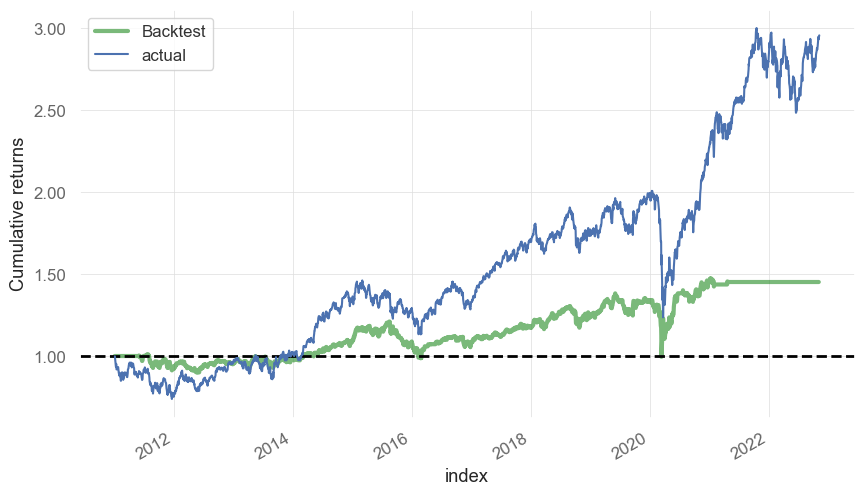

In [3]:
class MeanReversion(bt.Strategy):
    params = (
        ('period', 100),
        ('deviation', 2),
        ('trail_percent', 0.03),
    )

    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.period
        )
        self.order = None
        self.stop_price = None

    def next(self):
        if not self.position:
            if self.data.close < self.sma[0] - self.params.deviation:
                self.order = self.buy()
                self.stop_price = self.data.close * (1 - self.params.trail_percent)
        else:
            if self.data.close > self.sma[0] + self.params.deviation:
                self.close()
                self.order = None
                self.stop_price = None
            elif self.stop_price is not None and self.data.close < self.stop_price:
                self.close()
                self.order = None
                self.stop_price = None
            else:
                self.stop_price = self.data.close * (1 - self.params.trail_percent)

class TrendFollowing(bt.Strategy):
    params = (
        ('sma_period', 250),
        ('stop_loss', 0.05),
        ('take_profit', 0.10),
    )

    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.sma_period
        )

    def next(self):
        if not self.position:
            if self.data.close[0] > self.sma[0]:
                self.buy(target=self.data.close[0] * (1 + self.params.take_profit),
                         exectype=bt.Order.Stop)
        else:
            if self.data.close[0] < self.data.close[-1] * (1 - self.params.stop_loss):
                self.sell()

class FridayTrendFollowing(bt.Strategy):
    params = (
        ('sma_period', 250),
        ('stop_loss', 0.05),
        ('take_profit', 0.10),
    )

    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.sma_period
        )

    def next(self):
        if not self.position:
            if self.data.datetime.date().weekday() == 4:
                if self.data.close[0] > self.sma[0]:
                    self.buy(target=self.data.close[0] * (1 + self.params.take_profit),
                             exectype=bt.Order.Stop)
        else:
            if self.data.close[0] < self.data.close[-1] * (1 - self.params.stop_loss):
                self.sell()

class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order is not None:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

# Create the cerebro object and add the strategies
cerebro = bt.Cerebro()

# Load the data and run the backtest
data = bt.feeds.YahooFinanceCSVData(
        dataname='../nifty_daily_continous.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2011, 1, 3),
        # Do not pass values before this date
        todate=datetime.datetime(2022, 11, 7),
        # Do not pass values after this date
        reverse=False)
cerebro.adddata(data)

cerebro.addstrategy(MeanReversion)
#cerebro.addstrategy(FridayTrendFollowing)
cerebro.addstrategy(TrendFollowing)
#cerebro.addstrategy(TestStrategy)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
qs.reports.html(returns, output='stats.html', title='MeanReversal And TrendFollowing')

'''data = cerebro.plot()
data[0][0].savefig("mean_trend_strategy.png")'''

# Plot the cumulative sum using Pyfolio
pf.plotting.plot_rolling_returns(returns)
plt.plot(nifty_1day['cumulative_returns'], label='actual')
plt.legend()
plt.savefig("mean_trend.png")